In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(cowplot)
library(ggplot2)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [ ]:
data <- read.csv("listings.csv", header = TRUE) %>%
    select(-id, -name, -host_id, -host_name, -host_since, -neighbourhood_cleansed, -property_type, -license)
data <- na.omit(data)
#data["beds_per_accomodate"] = round(data$accommodates / data$beds, 2)
# data <- data %>%
#    filter(beds != 0)
# data <- data %>%
#     select(-beds, -accommodates)
data <- data %>%
    filter(host_response_time != 'N/A')
    
superhost_count <- data %>% count(host_is_superhost) %>% arrange(desc(n))
data <- data %>% 
    filter(host_is_superhost != superhost_count$host_is_superhost[3])


data <- data %>%
    mutate(host_response_time = as.factor(host_response_time) ,
           host_response_rate = as.numeric(host_response_rate), 
           host_is_superhost = as.factor(host_is_superhost), 
           neighbourhood_group_cleansed = as.factor(neighbourhood_group_cleansed), 
           room_type = as.factor(room_type),
           instant_bookable = as.factor(instant_bookable))

head(data)

,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
1,a few days or more,0.2,f,Other Cities,34.10933,-118.0731,Private room,2,1.0,1,1,49,1,364,1,3.00,f
2,within an hour,1.0,t,Other Cities,34.01559,-118.4941,Entire home/apt,2,1.0,0,1,231,5,193,44,4.93,t
3,within a few hours,1.0,f,City of Los Angeles,33.99017,-118.4225,Entire home/apt,7,1.0,2,5,110,30,117,368,4.61,f
4,within an hour,1.0,t,City of Los Angeles,33.98258,-118.4643,Entire home/apt,6,3.5,4,4,1179,2,356,35,4.97,f
5,within an hour,1.0,t,City of Los Angeles,34.08817,-118.3655,Entire home/apt,8,4.5,4,4,1244,3,141,10,5.00,f
6,within an hour,1.0,t,Other Cities,34.09130,-118.3519,Entire home/apt,5,1.0,2,3,213,2,244,23,4.74,t


In [40]:
dim(data)

[1] 25368    16

In [3]:
colSums(is.na(data))

host_response_time           host_response_rate 
                           0                            0 
           host_is_superhost neighbourhood_group_cleansed 
                           0                            0 
                    latitude                    longitude 
                           0                            0 
                   room_type                    bathrooms 
                           0                            0 
                    bedrooms                        price 
                           0                            0 
              minimum_nights             availability_365 
                           0                            0 
           number_of_reviews         review_scores_rating 
                           0                            0 
            instant_bookable          beds_per_accomodate 
                           0                            0

In [4]:

data %>% count(host_response_time) %>% mutate(prop = n / nrow(data))

host_response_time,n,prop
<fct>,<int>,<dbl>
a few days or more,457,0.01767960
within a day,1181,0.04568842
within a few hours,3362,0.13006306
within an hour,20849,0.80656892


In [6]:
str(data)

'data.frame':	25849 obs. of  16 variables:
 $ host_response_time          : Factor w/ 4 levels "a few days or more",..: 1 4 3 4 4 4 4 3 4 4 ...
 $ host_response_rate          : num  0.2 1 1 1 1 1 1 1 1 1 ...
 $ host_is_superhost           : Factor w/ 3 levels "","f","t": 2 3 2 3 3 3 3 2 2 1 ...
 $ neighbourhood_group_cleansed: Factor w/ 3 levels "City of Los Angeles",..: 2 2 1 1 1 2 1 1 2 2 ...
 $ latitude                    : num  34.1 34 34 34 34.1 ...
 $ longitude                   : num  -118 -118 -118 -118 -118 ...
 $ room_type                   : Factor w/ 4 levels "Entire home/apt",..: 3 1 1 1 1 1 1 1 1 1 ...
 $ bathrooms                   : num  1 1 1 3.5 4.5 1 1 1 1 2 ...
 $ bedrooms                    : int  1 0 2 4 4 2 2 1 1 2 ...
 $ price                       : int  49 231 110 1179 1244 213 95 298 110 282 ...
 $ minimum_nights              : int  1 5 30 2 3 2 30 3 4 2 ...
 $ availability_365            : int  364 193 117 356 141 244 38 244 356 313 ...
 $ number_of_reviews 

In [ ]:
png("price_hist.png",width = 2000, height = 2000, res = 300)
hist(data$price, xlim = c(0, 5000), main = "Distribution of Price", xlab = "Price", ylab = "Count")
dev.off()

pdf 
  2

The distribution of the price column is right-skewed, thus we will try to apply a log transformation to the price column.

In [ ]:
png("log_price_hist.png",width = 2000, height = 2000, res = 300)
hist(log(data$price), main = "Distribution of the log price", xlab = "Log of Price")
dev.off()

pdf 
  2

$title
[1] "Nighborhood Cleansed Boxplot"

attr(,"class")
[1] "labels"

Warning message:
“Removed 633 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


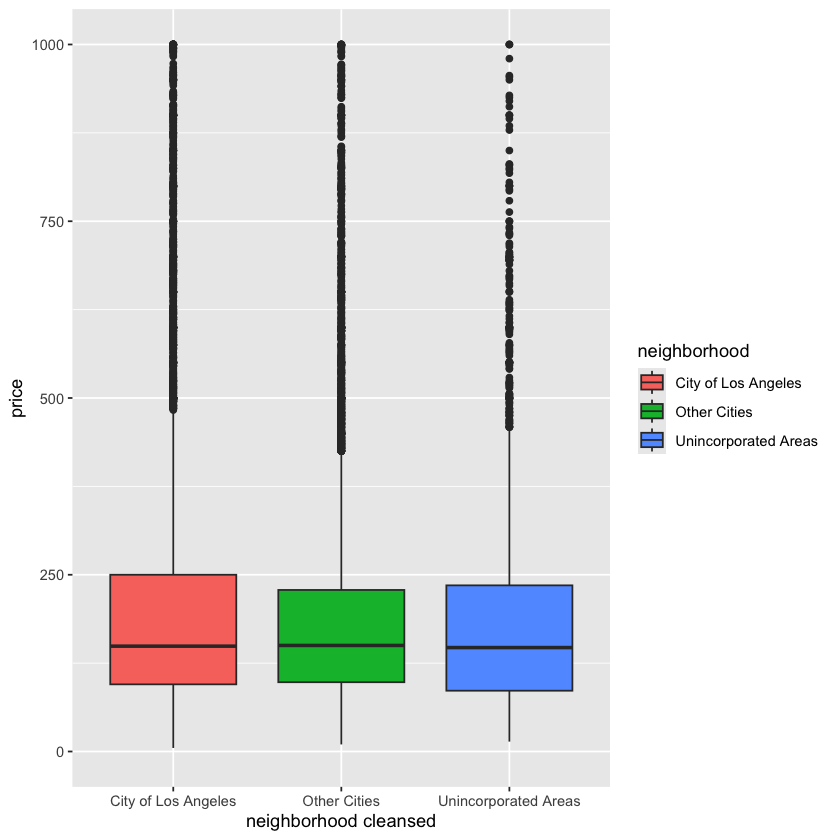

In [7]:
neighborhood_boxplot <- data %>%
    ggplot(aes(x=neighbourhood_group_cleansed,y = price, fill=neighbourhood_group_cleansed)) +
    geom_boxplot() +
    ylim(c(0, 1000)) +
    xlab("neighborhood cleansed") +
    ylab("price") +
    labs(fill = "neighborhood")
    ggtitle("Nighborhood Cleansed Boxplot")
neighborhood_boxplot

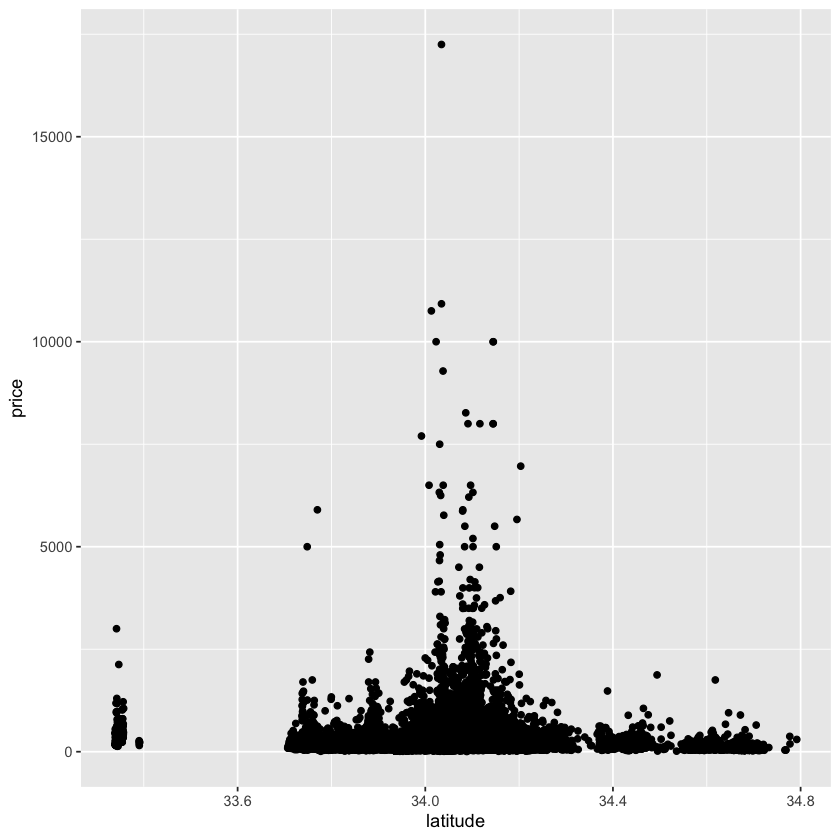

In [9]:
lat_price_plot <- data %>%
    ggplot(aes(latitude, price)) +
    geom_point()
lat_price_plot

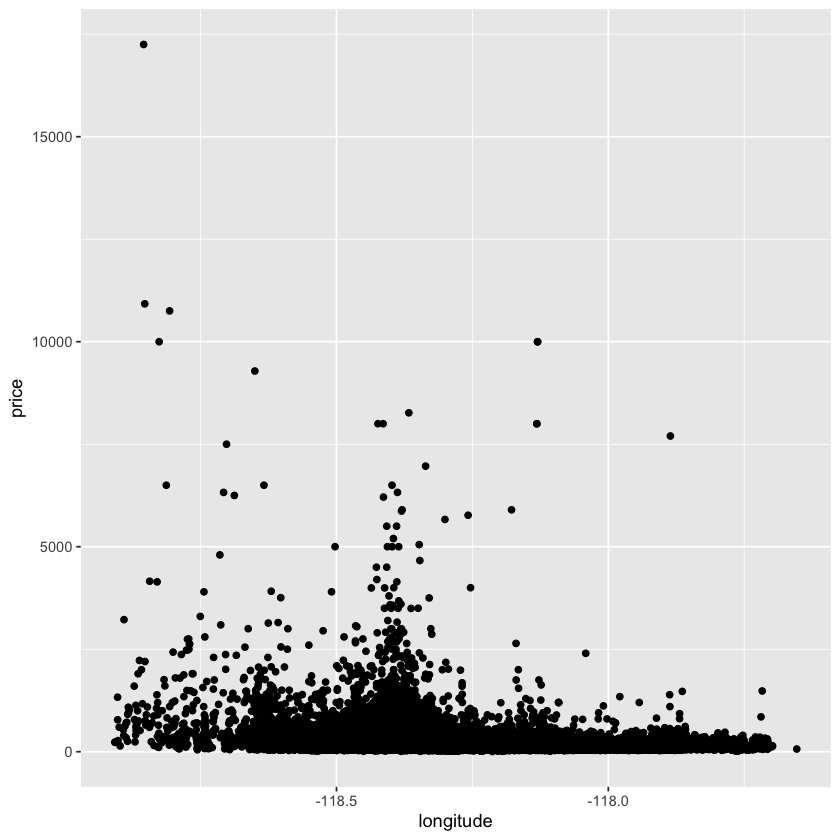

In [44]:
long_price_plot <- data %>%
    ggplot(aes(longitude, price)) +
    geom_point()
long_price_plot

In [8]:
colnames(data)

[1] "host_response_time"           "host_response_rate"          
 [3] "host_is_superhost"            "neighbourhood_group_cleansed"
 [5] "latitude"                     "longitude"                   
 [7] "room_type"                    "bathrooms"                   
 [9] "bedrooms"                     "price"                       
[11] "minimum_nights"               "availability_365"            
[13] "number_of_reviews"            "review_scores_rating"        
[15] "instant_bookable"             "beds_per_accomodate"

In [52]:
data <- data %>% select(-longitude, -latitude)


In [77]:
model <- lm(price ~ ., data = data)
summary(model) %>% tidy() %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-40823.38,1624.92,-25.12,0.00
host_response_timewithin a day,3.82,34.42,0.11,0.91
host_response_timewithin a few hours,32.11,36.83,0.87,0.38
host_response_timewithin an hour,9.06,37.32,0.24,0.81
host_response_rate,-74.63,39.03,-1.91,0.06
host_is_superhostt,-7.69,4.78,-1.61,0.11
neighbourhood_group_cleansedOther Cities,34.99,5.23,6.69,0.00
neighbourhood_group_cleansedUnincorporated Areas,5.63,7.76,0.73,0.47
latitude,-77.35,14.46,-5.35,0.00


In [78]:
summary(model)


Call:
lm(formula = price ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6568.4   -88.1   -14.9    48.9 15480.2 

Coefficients:
                                                   Estimate Std. Error t value
(Intercept)                                      -4.082e+04  1.625e+03 -25.123
host_response_timewithin a day                    3.819e+00  3.442e+01   0.111
host_response_timewithin a few hours              3.211e+01  3.683e+01   0.872
host_response_timewithin an hour                  9.060e+00  3.732e+01   0.243
host_response_rate                               -7.463e+01  3.903e+01  -1.912
host_is_superhostt                               -7.688e+00  4.778e+00  -1.609
neighbourhood_group_cleansedOther Cities          3.499e+01  5.233e+00   6.687
neighbourhood_group_cleansedUnincorporated Areas  5.629e+00  7.762e+00   0.725
latitude                                         -7.735e+01  1.446e+01  -5.349
longitude                                        -3.662e+

In [51]:
data %>% count(host_is_superhost) %>% arrange(desc(n))

host_is_superhost,n
<fct>,<int>
t,13796
f,10691


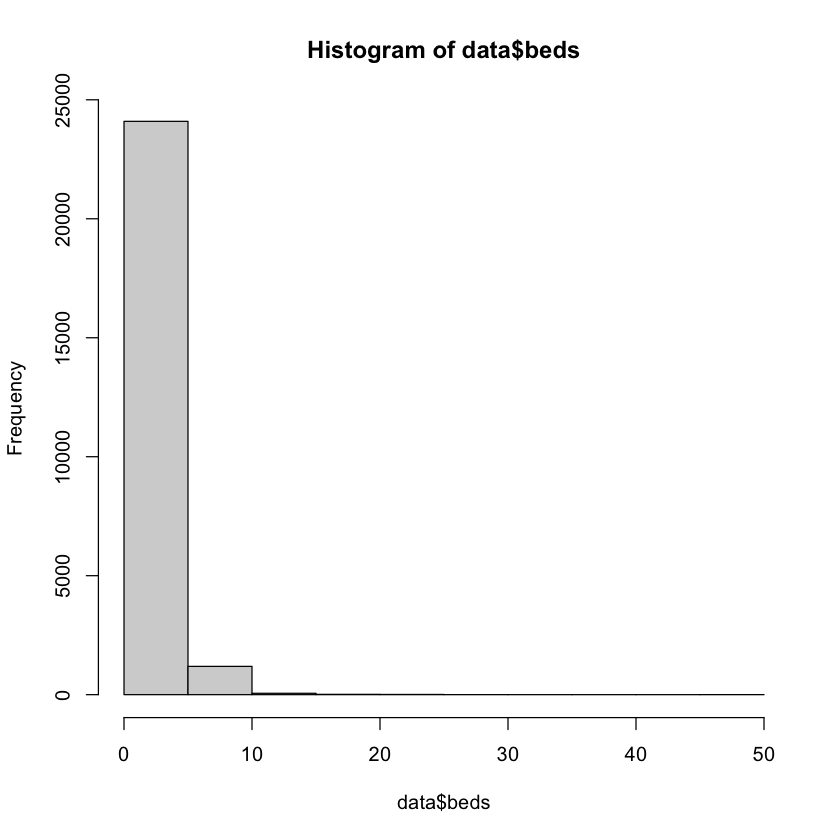

In [36]:
hist(data$beds)

$title
[1] "Host Rponse Time Boxplot"

attr(,"class")
[1] "labels"

Warning message:
“Removed 615 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


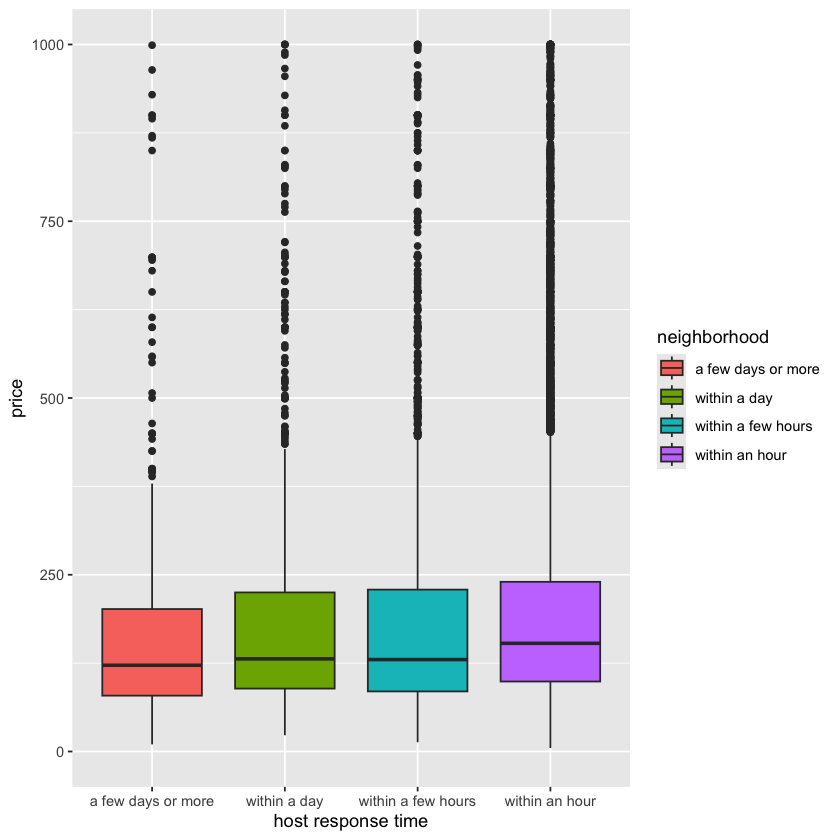

In [55]:
host_response_boxplot <- data %>%
    ggplot(aes(x=host_response_time,y = price, fill=host_response_time)) +
    geom_boxplot() +
    ylim(c(0, 1000)) +
    xlab("host response time") +
    ylab("price") +
    labs(fill = "neighborhood")
    ggtitle("Host Rponse Time Boxplot")
host_response_boxplot

$title
[1] "host is superhost Boxplot"

attr(,"class")
[1] "labels"

Warning message:
“Removed 615 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


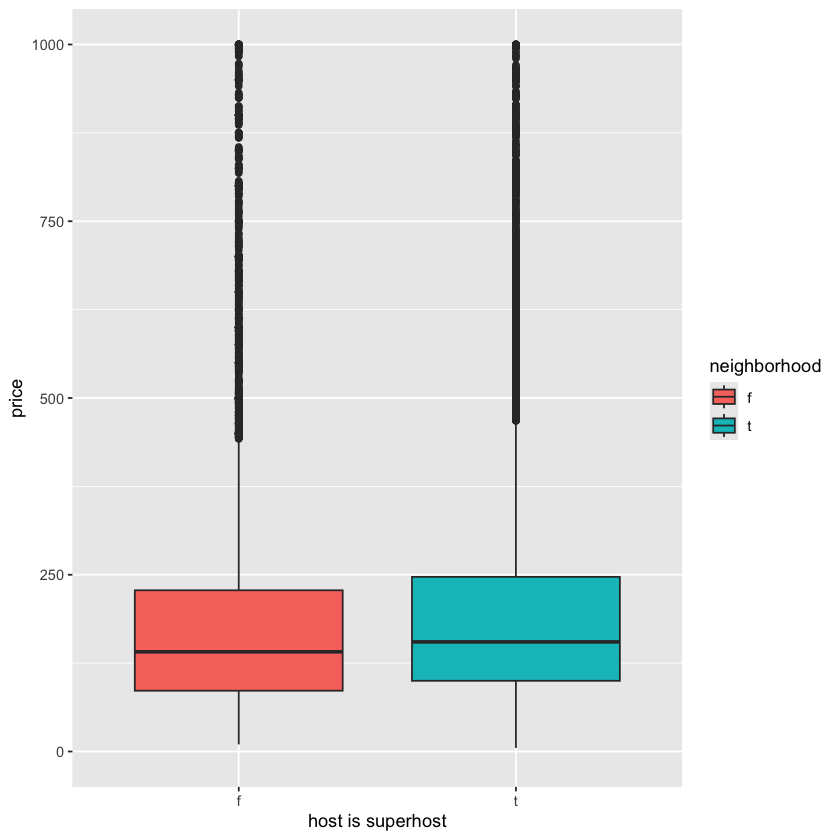

In [56]:
host_is_superhost_boxplot <- data %>%
    ggplot(aes(x=host_is_superhost,y = price, fill=host_is_superhost)) +
    geom_boxplot() +
    ylim(c(0, 1000)) +
    xlab("host is superhost") +
    ylab("price") +
    labs(fill = "neighborhood")
    ggtitle("host is superhost Boxplot")
host_is_superhost_boxplot

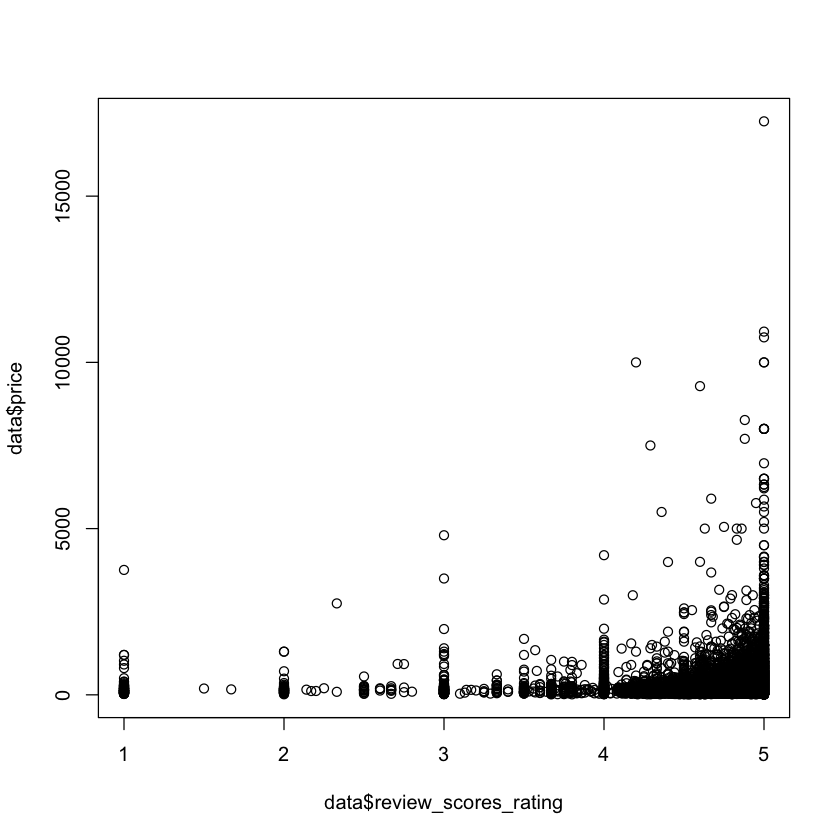

In [60]:
plot(data$review_scores_rating, data$price)

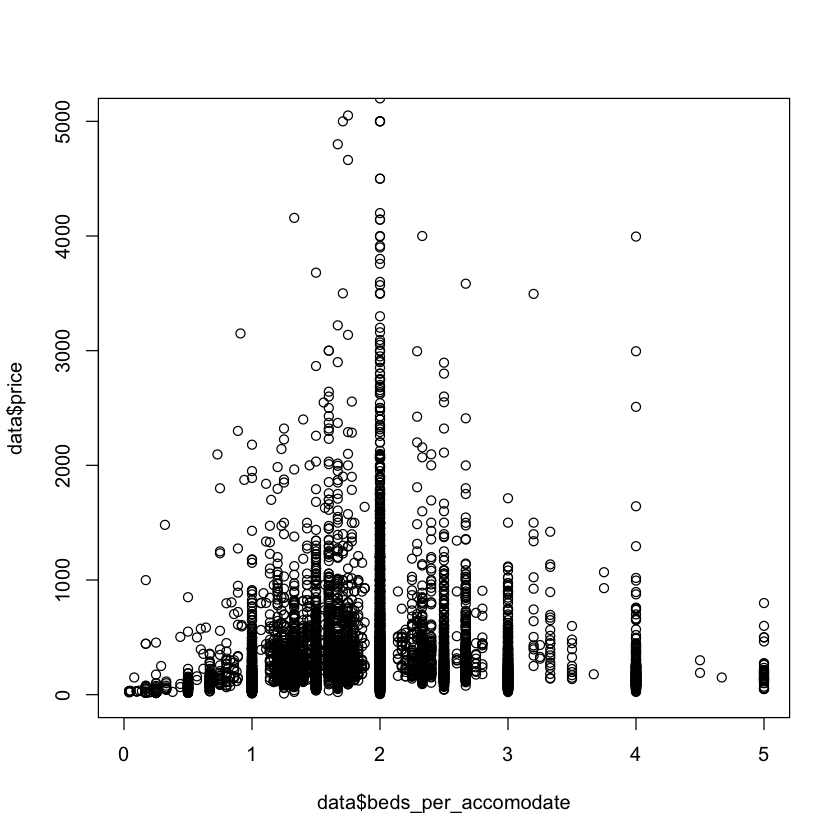

In [63]:
plot(data$beds_per_accomodate, data$price, xlim = c(0, 5), ylim = c(0, 5000))

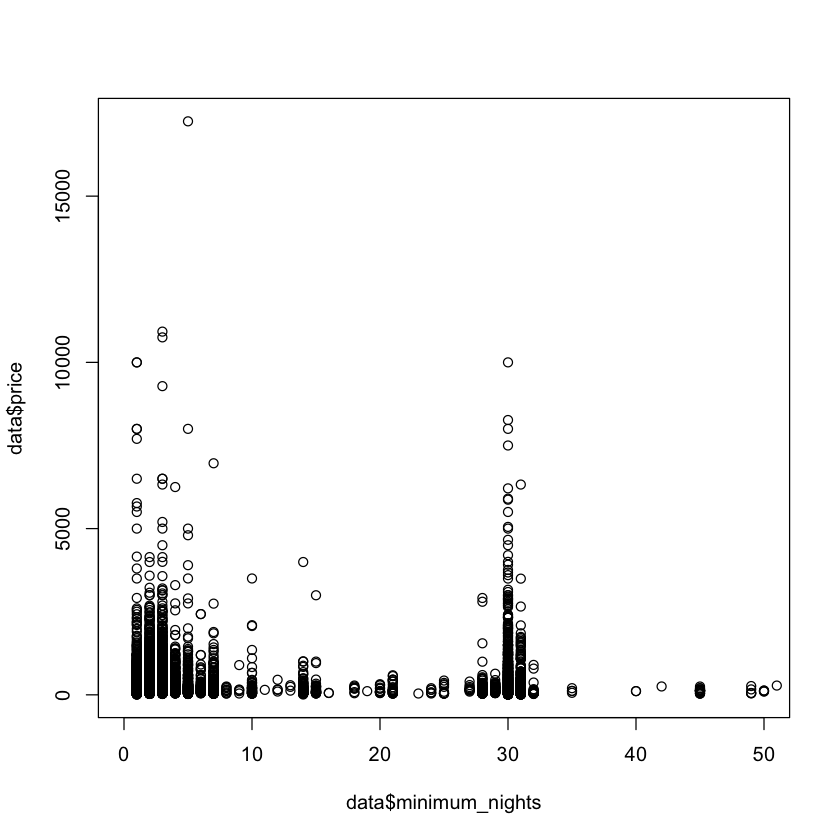

In [ ]:
plot(data$minimum_nights, data$price)

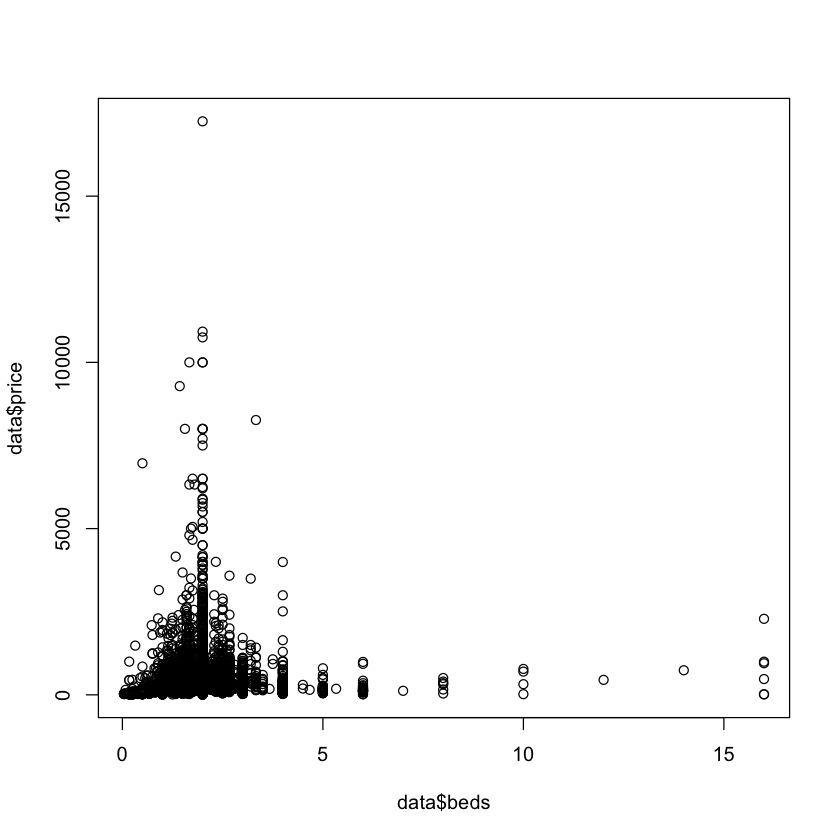

In [66]:
plot(data$beds, data$price)

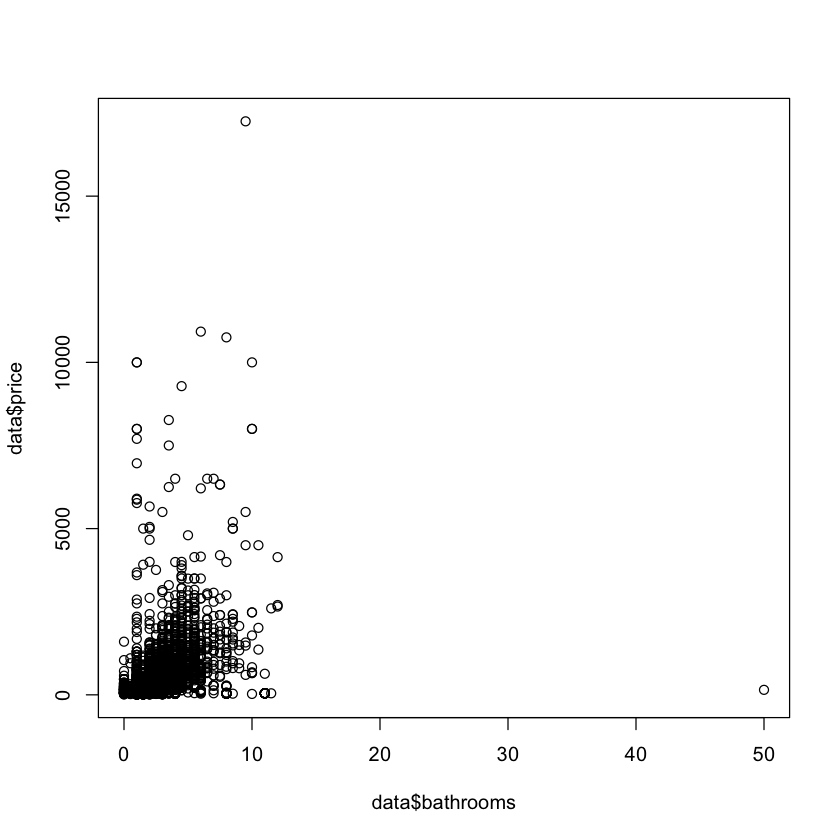

In [67]:
plot(data$bathrooms, data$price)

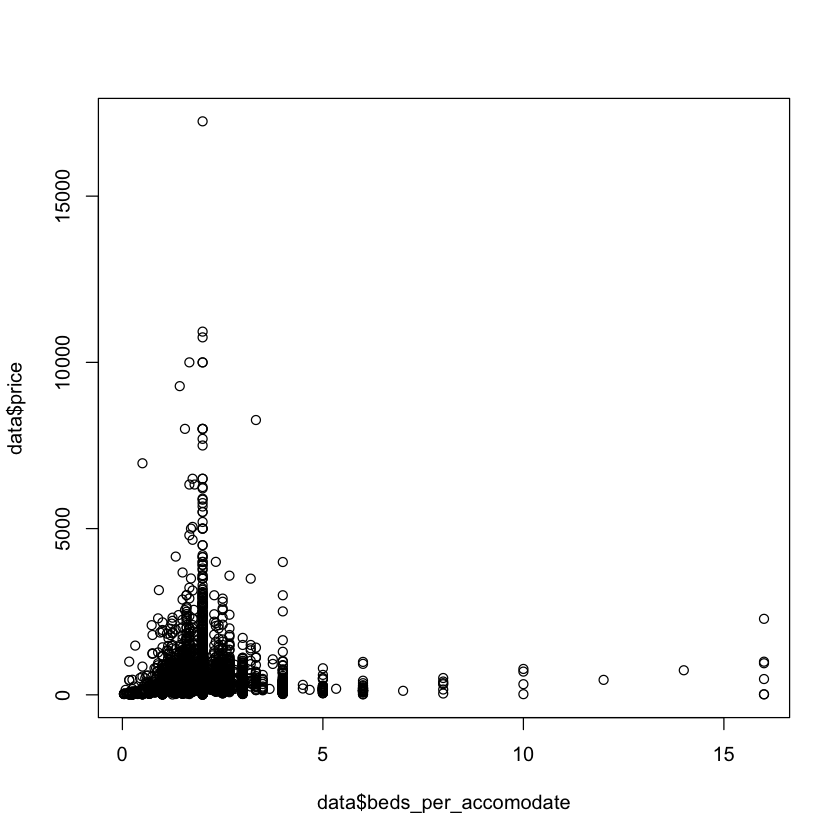

In [68]:
plot(data$beds_per_accomodate, data$price)

In [81]:
model <- lm(log(price) ~ bathrooms, data = data)
summary(model)


Call:
lm(formula = log(price) ~ bathrooms, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.0818  -0.3648   0.0182   0.3825   4.3457 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.492570   0.007565   593.9   <2e-16 ***
bathrooms   0.371997   0.003887    95.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6778 on 24485 degrees of freedom
Multiple R-squared:  0.2722,	Adjusted R-squared:  0.2722 
F-statistic:  9159 on 1 and 24485 DF,  p-value: < 2.2e-16


In [71]:
model <- lm(price ~ beds_per_accomodate, data = data)
summary(model)


Call:
lm(formula = price ~ beds_per_accomodate, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
 -633.8  -144.8   -90.0     6.2 17006.2 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          186.119      7.679  24.238  < 2e-16 ***
beds_per_accomodate   28.856      3.769   7.656 1.99e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 407.5 on 24485 degrees of freedom
Multiple R-squared:  0.002388,	Adjusted R-squared:  0.002347 
F-statistic: 58.61 on 1 and 24485 DF,  p-value: 1.991e-14


In [75]:
data <- read.csv("listings.csv")
data <- na.omit(data)
model <- lm(price ~ accommodates, data = data)
summary(model)


Call:
lm(formula = price ~ accommodates, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
 -927.5   -99.2   -34.2    20.0 20225.2 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.1823     4.6141    0.04    0.968    
accommodates  58.8330     0.9132   64.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 437.4 on 28043 degrees of freedom
Multiple R-squared:  0.1289,	Adjusted R-squared:  0.1289 
F-statistic:  4151 on 1 and 28043 DF,  p-value: < 2.2e-16


In [74]:
colnames(data)

[1] "id"                           "name"                        
 [3] "host_id"                      "host_name"                   
 [5] "host_since"                   "host_response_time"          
 [7] "host_response_rate"           "host_is_superhost"           
 [9] "neighbourhood_cleansed"       "neighbourhood_group_cleansed"
[11] "latitude"                     "longitude"                   
[13] "property_type"                "room_type"                   
[15] "accommodates"                 "bathrooms"                   
[17] "bedrooms"                     "beds"                        
[19] "price"                        "minimum_nights"              
[21] "availability_365"             "number_of_reviews"           
[23] "review_scores_rating"         "license"                     
[25] "instant_bookable"